# ゾンデデータ

指定した水平地点の近くのゾンデデータを取得し, 鉛直プロファイルを描くノートブックです.

今回は国内にフォーカスし気象庁サイトからデータを取得しています.


以下サイトを参考にしています.
* 過去データURLの取得 https://qiita.com/OSAKO/items/d25b8484d35ef4fe19e0
* 過去データURLにアクセスしデータ取得 https://qiita.com/tmiyama/items/f9cec233049b42f32965

全球を考える場合ワイオミング大学のサイトが有用ですが, まだ対応していません.
* https://weather.uwyo.edu/upperair/sounding.html
* https://www.dpac.dpri.kyoto-u.ac.jp/enomoto/pymetds/Upperair.html



## ライブラリの読込
* numpy: 数値計算ライブラリ
* matplotlib: 描画ライブラリ
* pandas: データ処理ライブラリ
* urllib: スクレイピング関係
* bs4: スクレイピング関係

スクレイピング周りでエラーが出た際はlxml, html5libをインストールすると解決する可能性がある. ( https://prograshi.com/language/python/python-pandas-read_html-errors-debug/ ).
例えば, condaを使っている場合「conda install -c conda-forge lxml」や「conda install html5lib」

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import requests
import datetime

import urllib.request
from bs4 import BeautifulSoup

plt.rcParams["font.size"]=15

## 設定
* 地点の指定は, 適当な緯度・経度か, 観測地点名. 前者の場合, 最も近い観測地点を同定して使用する.


In [2]:
savefig = True
dir_out = "./fig/"

# Target location
by_target_pos = True
# r-ccs
#lon0 = 135.2207105
#lat0 = 34.6533937
# tokyo station
lon0 = 139.7671248
lat0 = 35.6812362
# tsukuba
#lon0 = 140.1115746
#lat0 = 36.0827355

by_target_name = not by_target_pos
tname = "潮岬"


# Target period
year = 2007
month = 7
day = 15
#year = 2024
#month = 5
#day = 31
hour = 9
jstdatetime = datetime.datetime(year,month,day,hour)
utcdatetime = jstdatetime-datetime.timedelta(hours=9)

datatype0 = "hourly"

if by_target_name==by_target_pos:
    print("CAUTION: Only one of 'by_target_name' or 'by_target_pos' should be True")

varnamedic = {"気圧(hPa)":"PRES (hPa)",  "ジオポテンシャル 高度(m)" : "Z (m)" ,  "気温(℃)":"TEMP (℃)", "相対湿度(%)":"RH (%)",  "風速(m/s)":"WSPD (m/s)","風向(°)":"WDIR (°)"}


## 過去データURLを取得

* 気象庁サイトからURLを同定するための情報を取得
* 観測地点station・観測地点リンクstation_link・観測地点その他情報(位置情報など)station_etcを取得

In [3]:
url = "https://www.data.jma.go.jp/obd/stats/etrn/upper/select/prefecture.php?year=&month=&day=&hour=&atm=&point="
html = urllib.request.urlopen(url)
soup = BeautifulSoup(html, 'html.parser')
elements = soup.find_all('area')

station_etc_list = []
station_list = []
station_link_list = []

for element in elements:
    try:
        station_etc_list.append(element["onmouseover"])
        #station_list.append(element['alt'])
        station_list.append(element['alt'].split("\u3000")[0])
        station_link_list.append(element['href'].strip('../'))
    except KeyError:
        pass

for station, station_link in zip(station_list, station_link_list):
    print("Station:", station,station_link)    

station_lat_list = [float(etc.split("javascript:viewPoint(")[1].split(",")[3][1:-1]) + float(etc.split("javascript:viewPoint(")[1].split(",")[4][1:-1])/60  for etc in station_etc_list]
station_lon_list = [float(etc.split("javascript:viewPoint(")[1].split(",")[5][1:-1]) + float(etc.split("javascript:viewPoint(")[1].split(",")[6][1:-1])/60  for etc in station_etc_list]

lat = np.array(station_lat_list)
lon = np.array(station_lon_list)


Station: 稚内 index.php?year=&month=&day=&hour=&view=&point=47401
Station: 札幌 index.php?year=&month=&day=&hour=&view=&point=47412
Station: 釧路 index.php?year=&month=&day=&hour=&view=&point=47418
Station: 根室 index.php?year=&month=&day=&hour=&view=&point=47420
Station: 秋田 index.php?year=&month=&day=&hour=&view=&point=47582
Station: 仙台 index.php?year=&month=&day=&hour=&view=&point=47590
Station: 輪島 index.php?year=&month=&day=&hour=&view=&point=47600
Station: 館野 index.php?year=&month=&day=&hour=&view=&point=47646
Station: 八丈島 index.php?year=&month=&day=&hour=&view=&point=47678
Station: 松江 index.php?year=&month=&day=&hour=&view=&point=47741
Station: 米子 index.php?year=&month=&day=&hour=&view=&point=47744
Station: 潮岬 index.php?year=&month=&day=&hour=&view=&point=47778
Station: 福岡 index.php?year=&month=&day=&hour=&view=&point=47807
Station: 鹿児島 index.php?year=&month=&day=&hour=&view=&point=47827
Station: 名瀬／本茶峠 index.php?year=&month=&day=&hour=&view=&point=47909
Station: 石垣島 index.php?year=&month

* ターゲットに近い観測地点を同定; by_target_pos

あるいは

* 観測地点名からインテックス取得; by_target_name

その後, データ取得するURL作成

In [4]:
# Calculate distance from target
def ll2dist(lat1,lon1,lat2,lon2):
    R = 6371
    return R * np.arccos(
        np.sin(np.radians(lat1))*np.sin(np.radians(lat2))
        +np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*
        np.cos(np.radians(lon1)-np.radians(lon2)))

if by_target_pos:
    dist = ll2dist(lat0,lon0,lat,lon)
    argmin_dist = np.argmin(dist)
    station_index = argmin_dist
if by_target_name:
    station_index  = station_list.index(tname)

station = station_list[station_index]
station_link = station_link_list[station_index]
lon_target = station_lon_list[station_index]
lat_target = station_lat_list[station_index]

#print(station,station_link)

#ex: https://www.data.jma.go.jp/obd/stats/etrn/upper/view/hourly_usp.php?year=2022&month=4&day=19&hour=21&atm=&point=47646&view=

datatype = datatype0 + "_usp.php?"
url = "https://www.data.jma.go.jp/obd/stats/etrn/upper/view/" + datatype + station_link.split("?")[1].replace("year=",f"year={year}").replace("month=",f"month={month}").replace("day=",f"day={day}").replace("hour=",f"hour={hour}") + "&atm="

print(station,f"({lon_target},{lat_target})",url)


館野 (140.13333333333333,36.05) https://www.data.jma.go.jp/obd/stats/etrn/upper/view/hourly_usp.php?year=2007&month=7&day=15&hour=9&view=&point=47646&atm=


* データ取得地点の確認

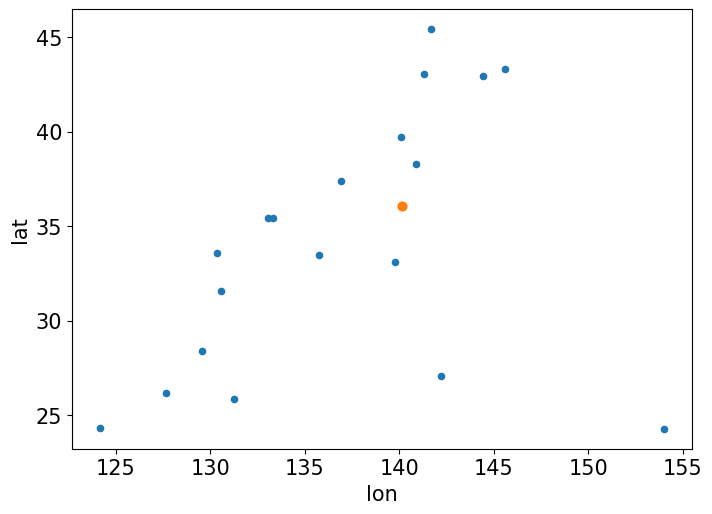

In [5]:
# check station location
fig,ax=plt.subplots(figsize=(8,6))
ax.scatter(lon[:-1],lat[:-1],s=20) # here the last station "showa" is excluded for visibility
ax.scatter(lon_target,lat_target,s=40)
ax.set_xlabel("lon")
ax.set_ylabel("lat")
ax.set_aspect("equal")
#ax.set_xlim(135,145)
#ax.set_ylim(30,40)


* データの取得・欠損値処理

In [6]:
# Get html data
table=pd.read_html(url)
print(table[0])
print("")
print(table[1])
df=table[1]
collist = df.columns

# Extract physical data
varlist = []
for col in collist:
    var = df[col].values
    if var.dtype == 'O':
        var[var=="-"]=np.nan
        var[var=="///"]=np.nan
        var = var.astype(float)
        print(var)
    varlist.append(var)


   気圧(hPa)  高度(m)  気温(℃)  相対湿度(%)  風速(m/s)  風向(°)
0    991.5     31   23.1       96      4.5     60

    気圧(hPa) ジオポテンシャル 高度(m)  気温(℃) 相対湿度(%) 風速(m/s) 風向(°)
0      1000            -44    ///     ///     ///     -
1       925            639   21.9      95      15   161
2       900            877   20.6      95      17   173
3       850           1371   18.1      94      19   184
4       800           1890   15.3      96      17   180
5       700           3015    9.8     100      24   189
6       600           4286    4.4      94      12   206
7       500           5752   -2.8      98      11   211
8       400           7496  -11.6      90       5   210
9       350           8509  -17.4      83       9   184
10      300           9648  -24.9      74       9   205
11      250          10947  -34.7      65       9   227
12      200          12464  -47.5     ///      16   247
13      175          13331  -55.2     ///      19   255
14      150          14297  -62.1     ///      22   274
15 

## 描画
* 各変数の鉛直分布

館野 hourly_usp https://www.data.jma.go.jp/obd/stats/etrn/upper/view/hourly_usp.php?year=2007&month=7&day=15&hour=9&view=&point=47646&atm=


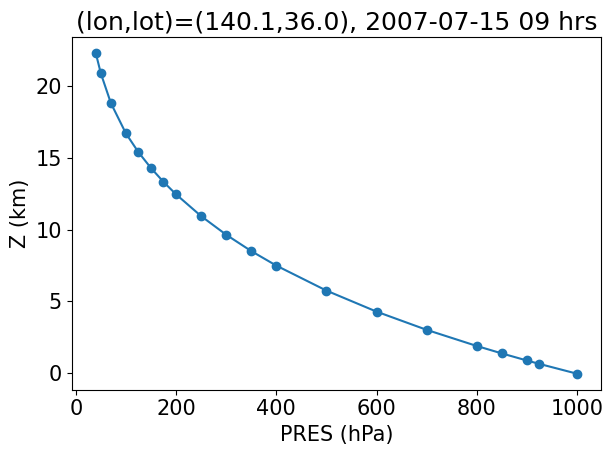

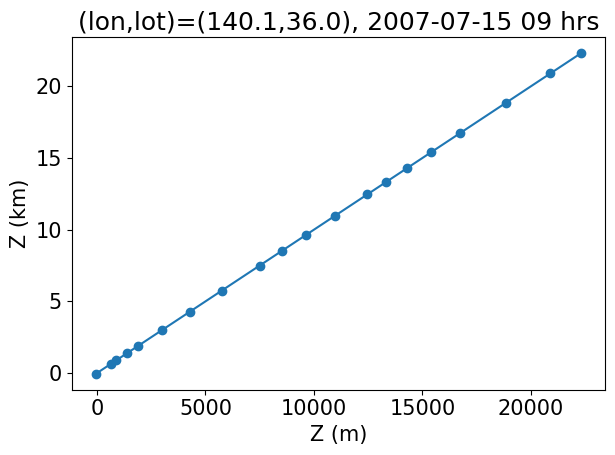

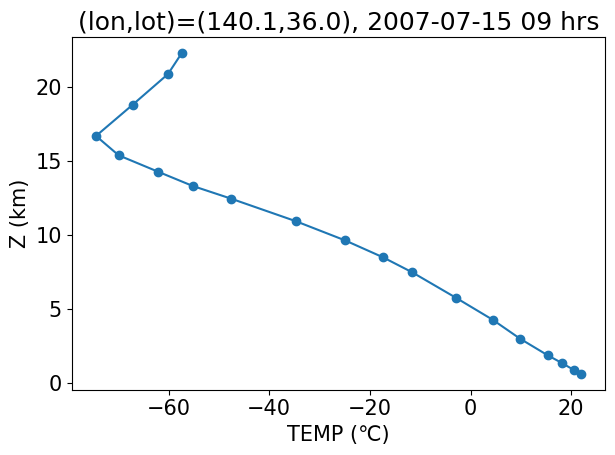

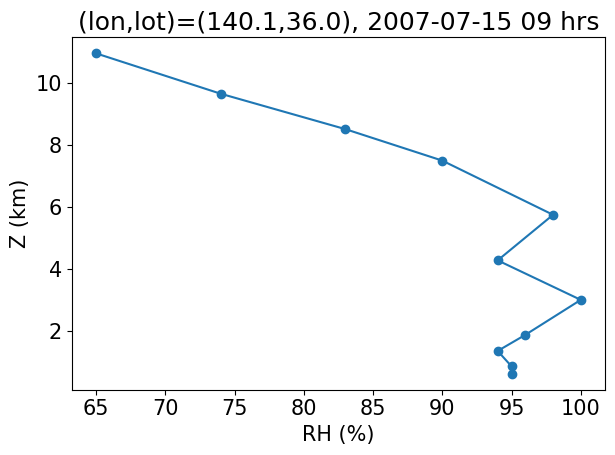

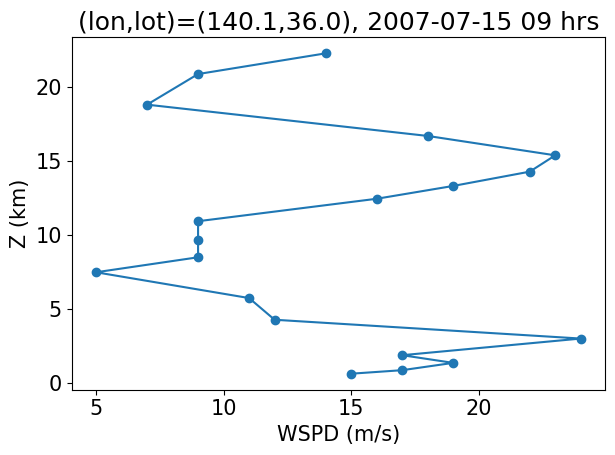

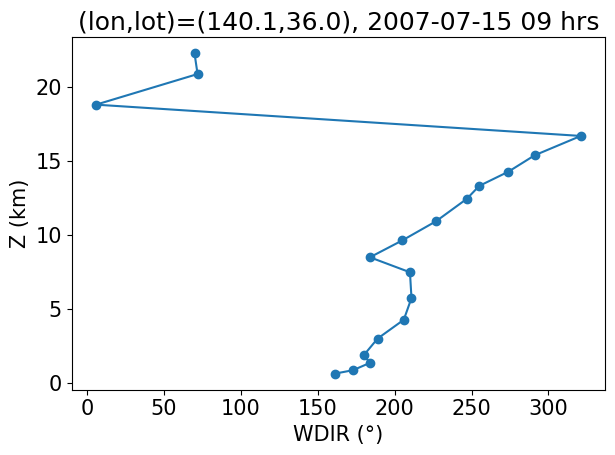

In [7]:
pres = varlist[0]
z = varlist[1]
time_target = jstdatetime.strftime("%Y-%m-%d %H hrs")

for var,col in zip(varlist,collist):
    fig,ax=plt.subplots()
    ax.plot(var, z/1000,marker="o")
    #ax.set_xticks(time[::4])
    #ax.set_xticklabels([jstdatetime.strftime("%H:%M") for jstdatetime in jstdatetimelist][::4])
    ax.set_title(f"(lon,lot)=({lon_target:.1f},{lat_target:.1f})" + ", " +time_target)
    ax.set_ylabel("Z (km)")
    ax.set_xlabel(varnamedic[col])
    fig.tight_layout()
    if savefig:
        flabel = f"Sonde_{varnamedic[col].split(" ")[0]}_{time_target.replace(" ","_")}_lon{lon_target}_lat{lat_target}_{station}"
        fig.savefig(dir_out + flabel + ".png")
print(station, datatype[:-5], url)